<a href="https://colab.research.google.com/github/iimjuhong/multimodal_project/blob/main/lane_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# 1. 환경 설정 및 패키지 설치
# ============================================

from google.colab import drive
drive.mount('/content/drive')

!pip install transformers datasets albumentations open3d opencv-python --quiet

import numpy as np
import pandas as pd
import cv2
import json
import open3d as o3d
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

# 데이터 경로
data_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Data/')

print("✅ 환경 설정 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.5 MB/s eta 0:00:00
✅ 환경 설정 완료!


In [ ]:
# RGB 이미지 위치 찾기
print("🔍 이미지 폴더 찾는 중...\n")

possible_names = ['color', 'images', 'image', 'rgb', 'Color', 'Images']

for name in possible_names:
    path = data_dir / name
    if path.exists():
        files = list(path.glob('*.jpg'))
        print(f"✅ 발견: {name}/")
        print(f"   파일 수: {len(files)}")
        if files:
            print(f"   예시: {files[0].name}")
        break
else:
    print("❌ 이미지 폴더를 찾을 수 없습니다!")
    print(f"\n📂 {data_dir} 내부 폴더 목록:")
    for item in data_dir.iterdir():
        if item.is_dir():
            print(f"  - {item.name}/")

🔍 이미지 폴더 찾는 중...

✅ 발견: images/
   파일 수: 7600
   예시: 21_211941_220817_02.jpg


In [ ]:
# ============================================
# 2. VL.tar 압축 해제 (차선 라벨)
# ============================================

import tarfile
import zipfile
import shutil

vl_tar_path = Path('/content/drive/MyDrive/AI-Hub/VL.tar')
extract_step1 = Path('/content/VL_step1/')
extract_step2 = Path('/content/VL_extracted/')

print("📦 VL.tar 압축 해제 중...\n")

# Step 1: tar 압축 해제
if extract_step1.exists():
    shutil.rmtree(extract_step1)
extract_step1.mkdir(exist_ok=True)

with tarfile.open(vl_tar_path, 'r') as tar:
    tar.extractall(extract_step1)

# Step 2: 분할 zip 합치기
if extract_step2.exists():
    shutil.rmtree(extract_step2)
extract_step2.mkdir(exist_ok=True)

part_files = sorted(extract_step1.rglob('*.zip.part*'))

if part_files:
    base_name = str(part_files[0]).split('.part')[0]
    merged_zip = Path(str(base_name) + '_merged.zip')

    print(f"분할 파일 합치는 중... ({len(part_files)}개)")

    with open(merged_zip, 'wb') as outfile:
        for part in part_files:
            with open(part, 'rb') as infile:
                outfile.write(infile.read())

    print(f"zip 압축 해제 중...")

    with zipfile.ZipFile(merged_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_step2)

print("✅ VL.tar 압축 해제 완료!")

📦 VL.tar 압축 해제 중...



/tmp/ipython-input-570244940.py:21: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_step1)


분할 파일 합치는 중... (1개)
zip 압축 해제 중...
✅ VL.tar 압축 해제 완료!


In [ ]:
# ============================================
# 3. 차선 라벨 정리 및 복사
# ============================================

vl_extracted = Path('/content/VL_extracted/2D/')
labels_output = data_dir / 'lane_labels'

print("📋 차선 라벨 복사 중...\n")

if labels_output.exists():
    shutil.rmtree(labels_output)
labels_output.mkdir(parents=True)

vl_json_files = list(vl_extracted.rglob('*.json'))

for json_file in vl_json_files:
    filename = json_file.name
    output_path = labels_output / filename
    shutil.copy(json_file, output_path)

print(f"✅ 차선 라벨 복사 완료: {len(vl_json_files):,}개")

📋 차선 라벨 복사 중...

✅ 차선 라벨 복사 완료: 7,600개


In [ ]:
# ============================================
# [초고속] LiDARProjector
# ============================================

import numpy as np
import cv2
import open3d as o3d
import json
import warnings

class FastLiDARProjector:
    """초고속 LiDAR → Depth (벡터화 + 빠른 inpainting)"""

    def __init__(self, meta_data_path: str):
        with open(meta_data_path, 'r', encoding='utf-8') as f:
            meta_data = json.load(f)

        calib = meta_data['calibration']
        cam_front = calib['camera']['front']
        intrinsic = cam_front['Intrinsic']

        self.K = np.array([
            [intrinsic['Fx'], 0, intrinsic['Cx']],
            [0, intrinsic['Fy'], intrinsic['Cy']],
            [0, 0, 1]
        ], dtype=np.float64)

        dist = intrinsic['Distortion']
        self.dist_coeffs = np.array([
            dist['Param0'], dist['Param1'],
            dist['Param2'], dist['Param3'],
            dist.get('Param4', 0.0)
        ], dtype=np.float64)

    def project_lidar_to_image(self, pcd_path: str, image_shape):
        H, W = image_shape

        # 1. PCD 로드 (조용히)
        try:
            o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)
            pcd = o3d.io.read_point_cloud(str(pcd_path))
            points = np.asarray(pcd.points)
        except:
            return np.zeros((H, W), dtype=np.float32)

        if len(points) == 0:
            return np.zeros((H, W), dtype=np.float32)

        # 2. 좌표 변환
        points_cam = np.stack([
            points[:, 0],
            points[:, 2],
            points[:, 1]
        ], axis=1)

        # 3. 전방 필터링
        valid_mask = points_cam[:, 2] > 0.5
        points_cam = points_cam[valid_mask]

        if len(points_cam) == 0:
            return np.zeros((H, W), dtype=np.float32)

        # 4. 투영
        rvec = np.zeros((3, 1))
        tvec = np.zeros((3, 1))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            points_2d, _ = cv2.projectPoints(
                points_cam, rvec, tvec,
                self.K, self.dist_coeffs
            )

        points_2d = points_2d.reshape(-1, 2)

        # 5. 픽셀 좌표
        u = np.round(points_2d[:, 0]).astype(np.int32)
        v = np.round(points_2d[:, 1]).astype(np.int32)
        depths = points_cam[:, 2]

        # 6. 범위 필터링
        valid = (u >= 0) & (u < W) & (v >= 0) & (v < H)
        u = u[valid]
        v = v[valid]
        depths = depths[valid]

        if len(depths) == 0:
            return np.zeros((H, W), dtype=np.float32)

        # 7. ⭐ 벡터화된 Depth Map 생성 (100배 빠름!)
        # 내림차순 정렬 → 작은 값(가까운 거리)이 나중에 덮어씀
        sort_idx = np.argsort(depths)[::-1]

        depth_map = np.zeros((H, W), dtype=np.float32)
        depth_map[v[sort_idx], u[sort_idx]] = depths[sort_idx]

        # 8. ⭐ 빠른 Inpainting (5배 빠름!)
        mask = (depth_map > 0).astype(np.uint8)
        if mask.sum() > 0:
            depth_map = cv2.inpaint(
                depth_map,
                1 - mask,
                inpaintRadius=2,  # ← 5에서 2로 (5배 빠름)
                flags=cv2.INPAINT_TELEA
            )

        return depth_map

print("✅ FastLiDARProjector 정의 완료!")

✅ FastLiDARProjector 정의 완료!


In [ ]:
# ============================================
# [병렬 처리] Depth 사전 계산
# ============================================

from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

print("\n📦 병렬 Depth 사전 계산 시작\n")
print("="*70)

# 저장 경로
depth_cache_dir = data_dir / 'depth_cache_512'
depth_cache_dir.mkdir(exist_ok=True)

print(f"저장 위치: {depth_cache_dir}")
print(f"CPU 코어: {multiprocessing.cpu_count()}개\n")


def process_one_sample(row, split, data_dir, output_dir):
    """하나의 샘플 처리 (병렬 실행용)"""
    try:
        filename = row['filename']
        save_name = f"{split}_{filename.replace('.jpg', '.npy')}"
        save_path = output_dir / save_name

        # 이미 있으면 스킵
        if save_path.exists():
            return None

        # 경로
        lidar_path = data_dir / 'lidar' / filename.replace('.jpg', '.pcd')
        meta_path = data_dir / 'calibration' / f"{row['scene']}_meta_data.json"

        # Projector 생성 (각 프로세스마다 독립적)
        projector = FastLiDARProjector(str(meta_path))

        # Depth 계산
        depth = projector.project_lidar_to_image(str(lidar_path), (1080, 1920))

        # 512x512 리사이즈
        depth_512 = cv2.resize(depth, (512, 512), interpolation=cv2.INTER_LINEAR)

        # 저장
        np.save(save_path, depth_512.astype(np.float16))

        return save_name
    except Exception as e:
        return None


# Train 처리
print("🔄 Train Depth 병렬 계산 중...")

train_df = pd.read_csv(data_dir / 'train_metadata.csv')

# 처리할 샘플만 선택
train_tasks = []
for idx in range(len(train_df)):
    row = train_df.iloc[idx]
    save_name = f"train_{row['filename'].replace('.jpg', '.npy')}"
    save_path = depth_cache_dir / save_name

    if not save_path.exists():
        train_tasks.append(row)

print(f"  처리할 파일: {len(train_tasks):,} / {len(train_df):,}")

if train_tasks:
    # 병렬 실행
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_one_sample)(row, 'train', data_dir, depth_cache_dir)
        for row in train_tasks
    )
    print(f"  완료: {sum(1 for r in results if r is not None):,}개")


# Val 처리
print("\n🔄 Val Depth 병렬 계산 중...")

val_df = pd.read_csv(data_dir / 'val_metadata.csv')

val_tasks = []
for idx in range(len(val_df)):
    row = val_df.iloc[idx]
    save_name = f"val_{row['filename'].replace('.jpg', '.npy')}"
    save_path = depth_cache_dir / save_name

    if not save_path.exists():
        val_tasks.append(row)

print(f"  처리할 파일: {len(val_tasks):,} / {len(val_df):,}")

if val_tasks:
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_one_sample)(row, 'val', data_dir, depth_cache_dir)
        for row in val_tasks
    )
    print(f"  완료: {sum(1 for r in results if r is not None):,}개")


print("\n✅ Depth 사전 계산 완료!")

# 확인
train_depths = list(depth_cache_dir.glob('train_*.npy'))
val_depths = list(depth_cache_dir.glob('val_*.npy'))

print(f"\n📊 최종 결과:")
print(f"  Train: {len(train_depths):,}개")
print(f"  Val: {len(val_depths):,}개")
print(f"  용량: ~{sum(f.stat().st_size for f in train_depths + val_depths) / 1e9:.2f} GB")
print("="*70)


📦 병렬 Depth 사전 계산 시작

저장 위치: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/depth_cache_512
CPU 코어: 12개

🔄 Train Depth 병렬 계산 중...
  처리할 파일: 5,352 / 6,080


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

  완료: 5,318개

🔄 Val Depth 병렬 계산 중...
  처리할 파일: 1,520 / 1,520


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

  완료: 1,514개

✅ Depth 사전 계산 완료!

📊 최종 결과:
  Train: 6,046개
  Val: 1,514개
  용량: ~3.96 GB


In [ ]:
# ============================================
# Depth 생성 결과 확인
# ============================================

import pandas as pd
from pathlib import Path

data_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Data/')
depth_cache_dir = data_dir / 'depth_cache_512'

print("="*70)
print("📊 Depth 생성 결과 분석")
print("="*70)

# 1. 현재 상태
train_depths = list(depth_cache_dir.glob('train_*.npy'))
val_depths = list(depth_cache_dir.glob('val_*.npy'))

print(f"\n현재 저장된 Depth:")
print(f"  Train: {len(train_depths):,}개")
print(f"  Val: {len(val_depths):,}개")

# 2. CSV 기준
train_df = pd.read_csv(data_dir / 'train_metadata.csv')
val_df = pd.read_csv(data_dir / 'val_metadata.csv')

print(f"\nCSV 기준:")
print(f"  Train: {len(train_df):,}개")
print(f"  Val: {len(val_df):,}개")

# 3. 누락 확인
print(f"\n비교:")
print(f"  Train 누락: {len(train_df) - len(train_depths):,}개")
print(f"  Val 누락: {len(val_df) - len(val_depths):,}개")

# 4. 누락된 파일 찾기
train_depth_names = {f.stem.replace('train_', '') for f in train_depths}
missing_train = []

for idx in range(len(train_df)):
    row = train_df.iloc[idx]
    expected_name = row['filename'].replace('.jpg', '')
    if expected_name not in train_depth_names:
        missing_train.append(row['filename'])

if missing_train:
    print(f"\n⚠️ 누락된 Train 파일 (처음 10개):")
    for f in missing_train[:10]:
        print(f"  - {f}")

    # 누락된 파일 체크
    print(f"\n누락 파일 존재 여부 확인:")
    sample = missing_train[0]
    lidar_exists = (data_dir / 'lidar' / sample.replace('.jpg', '.pcd')).exists()
    image_exists = (data_dir / 'images' / sample).exists()
    label_exists = (data_dir / 'lane_labels' / sample.replace('.jpg', '.json')).exists()

    print(f"  샘플: {sample}")
    print(f"    LiDAR: {lidar_exists}")
    print(f"    Image: {image_exists}")
    print(f"    Label: {label_exists}")
else:
    print("\n✅ 누락 없음! 모든 파일 처리 완료!")

print("\n" + "="*70)

📊 Depth 생성 결과 분석

현재 저장된 Depth:
  Train: 6,046개
  Val: 1,514개

CSV 기준:
  Train: 6,080개
  Val: 1,520개

비교:
  Train 누락: 34개
  Val 누락: 6개

⚠️ 누락된 Train 파일 (처음 10개):
  - 08_080234_221012_07.jpg
  - 08_080234_221012_35.jpg
  - 08_080234_221012_01.jpg
  - 08_080234_221012_24.jpg
  - 08_080234_221012_29.jpg
  - 08_080234_221012_26.jpg
  - 08_080234_221012_39.jpg
  - 08_080234_221012_17.jpg
  - 08_080234_221012_20.jpg
  - 08_080234_221012_31.jpg

누락 파일 존재 여부 확인:
  샘플: 08_080234_221012_07.jpg
    LiDAR: True
    Image: True
    Label: True



In [ ]:
# ============================================
# [수정] MultimodalLaneDataset - 최종 완성 버전
# ============================================

import numpy as np
import json
import cv2
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd


def preload_all_depths_to_memory(depth_cache_dir):
    """모든 Depth를 메모리에 미리 로드"""
    depth_cache_dir = Path(depth_cache_dir)

    print("\n" + "="*70)
    print("🚀 Depth 메모리 사전 로딩 시작 (GPU 대기 시간 제거)")
    print("="*70)

    depth_memory_cache = {}

    # Train depths 로드
    print("\n📥 Train Depth 로딩 중...")
    train_depths = sorted(depth_cache_dir.glob('train_*.npy'))

    for depth_path in tqdm(train_depths, desc="Train"):
        key = depth_path.name
        depth_memory_cache[key] = np.load(depth_path).astype(np.float32)

    # Val depths 로드
    print("\n📥 Val Depth 로딩 중...")
    val_depths = sorted(depth_cache_dir.glob('val_*.npy'))

    for depth_path in tqdm(val_depths, desc="Val"):
        key = depth_path.name
        depth_memory_cache[key] = np.load(depth_path).astype(np.float32)

    total_size = sum(d.nbytes for d in depth_memory_cache.values()) / 1e9

    print(f"\n✅ Depth 메모리 로딩 완료!")
    print(f"  - Train: {len(train_depths):,}개")
    print(f"  - Val: {len(val_depths):,}개")
    print(f"  - 메모리 사용량: {total_size:.2f} GB")
    print("="*70 + "\n")

    return depth_memory_cache

In [ ]:
class MultimodalLaneDataset(Dataset):
    """메모리 캐시 Depth + JSON 라벨 → 마스크 변환 (최종 수정)"""

    def __init__(
        self,
        metadata_csv,
        data_dir,
        depth_memory_cache=None,
        split='train',
        transform=None,
        image_size=(512, 512),
        use_depth=True
    ):
        self.data_dir = Path(data_dir)
        self.depth_memory_cache = depth_memory_cache
        self.split = split
        self.transform = transform
        self.image_size = image_size
        self.use_depth = use_depth

        self.df = pd.read_csv(metadata_csv)

        self.color_dir = self.data_dir / 'images'
        self.label_dir = self.data_dir / 'lane_labels'

        print(f"✓ Dataset ({split}): {len(self.df):,} samples")
        print(f"  - Images: {self.color_dir}")
        print(f"  - Labels: {self.label_dir}")

    def __len__(self):
        return len(self.df)

    def _create_lane_mask_from_json(self, json_path, image_size):
        """JSON polygon → 세그멘테이션 마스크 (차선만!)"""
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        orig_w, orig_h = 1920, 1080
        target_w, target_h = image_size

        scale_x = target_w / orig_w
        scale_y = target_h / orig_h

        mask = np.zeros((target_h, target_w), dtype=np.uint8)

        # ⭐ 차선 클래스만 선택
        valid_lane_classes = ['whiteLane', 'yellowLane', 'stopLane']

        for anno in data.get('annotations', []):
            # 클래스 필터링
            anno_class = anno.get('class', '')
            if anno_class not in valid_lane_classes:
                continue

            if 'polygon' not in anno:
                continue

            polygon = np.array(anno['polygon'], dtype=np.float32).reshape(-1, 2)
            polygon[:, 0] *= scale_x
            polygon[:, 1] *= scale_y
            polygon = polygon.astype(np.int32)

            cv2.fillPoly(mask, [polygon], 1)

        return mask

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']

        # 1. RGB
        image = Image.open(self.color_dir / filename).convert('RGB')
        image = image.resize(self.image_size, Image.BILINEAR)

        # 2. Label (차선만!)
        label_filename = filename.replace('.jpg', '.json')
        label_path = self.label_dir / label_filename

        if label_path.exists():
            label = self._create_lane_mask_from_json(label_path, self.image_size)
        else:
            label = np.zeros(self.image_size[::-1], dtype=np.uint8)

        # 3. Depth
        if self.use_depth and self.depth_memory_cache is not None:
            depth_filename = filename.replace('.jpg', '.npy')
            depth_key = f"{self.split}_{depth_filename}"
            depth = self.depth_memory_cache.get(
                depth_key,
                np.zeros((512, 512), dtype=np.float32)
            )
        else:
            depth = np.zeros((512, 512), dtype=np.float32)

        # 4. Transform
        if self.transform:
            transformed = self.transform(
                image=np.array(image),
                mask=label,
                depth=depth
            )
            image = transformed['image']
            label = transformed['mask']
            depth = transformed['depth']
        else:
            image = np.array(image) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            label = torch.from_numpy(label).long()
            depth = torch.from_numpy(depth).float()

        # Depth normalization
        if isinstance(depth, np.ndarray):
            if depth.max() > 0:
                depth = depth / depth.max()
            depth = torch.from_numpy(depth).float()
        else:
            if depth.max() > 0:
                depth = depth / depth.max()

        # Depth: (H, W) → (1, H, W)
        if depth.dim() == 2:
            depth = depth.unsqueeze(0)

        return {
            'pixel_values': image,
            'depth': depth,
            'labels': label,
            'filename': filename
        }


def get_train_transforms():
    """Train용 Augmentation (Depth-safe)"""
    return A.Compose([
        # 1. Resize
        A.Resize(512, 512),

        # 2. Geometric Transforms (RGB + Depth 모두 적용)
        A.HorizontalFlip(p=0.5),
        A.Affine(  # ShiftScaleRotate 대신 Affine 사용 (warning 해결)
            scale=(0.85, 1.15),
            translate_percent=(-0.1, 0.1),
            rotate=(-10, 10),
            shear=(-5, 5),
            p=0.5
        ),

        # 3. Color/Intensity Augmentation (RGB에만 안전)
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=0.2,
                contrast_limit=0.2,
                p=1.0
            ),
            A.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1,
                p=1.0
            ),
        ], p=0.5),

        # 4. GaussNoise 제거 (문제의 원인)
        # 대신 GaussianBlur 사용 (더 안전)
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),

        # 5. Normalize
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),

        # 6. ToTensor
        ToTensorV2()
    ], additional_targets={
        'depth': 'image',
        'mask': 'mask'
    })


🧪 Dataset 생성 중...


🚀 Depth 메모리 사전 로딩 시작 (GPU 대기 시간 제거)

📥 Train Depth 로딩 중...


Train: 100%|██████████| 6046/6046 [01:15<00:00, 79.84it/s] 



📥 Val Depth 로딩 중...


Val: 100%|██████████| 1514/1514 [00:06<00:00, 227.57it/s]



✅ Depth 메모리 로딩 완료!
  - Train: 6,046개
  - Val: 1,514개
  - 메모리 사용량: 7.93 GB

✓ Dataset (train): 6,080 samples
  - Images: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/images
  - Labels: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/lane_labels
✓ Dataset (val): 1,520 samples
  - Images: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/images
  - Labels: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/lane_labels

✅ Dataset 생성 완료!
   Train: 6,080개
   Val: 1,520개

🔍 샘플 3개 검증:
----------------------------------------------------------------------

Sample 1: 08_084024_221012_04.jpg
  RGB: torch.Size([3, 512, 512])
  Depth: torch.Size([1, 512, 512]) (100.0% valid)
  Lane: torch.Size([512, 512]) (0.78% lane)

Sample 2: 21_201431_220817_36.jpg
  RGB: torch.Size([3, 512, 512])
  Depth: torch.Size([1, 512, 512]) (96.5% valid)
  Lane: torch.Size([512, 512]) (1.28% lane)

Sample 3: 21_204459_220817_35.jpg
  RGB: torch.Size([3, 512, 512])
  Depth: torch.Size([1, 512, 512]) (100.0% valid)

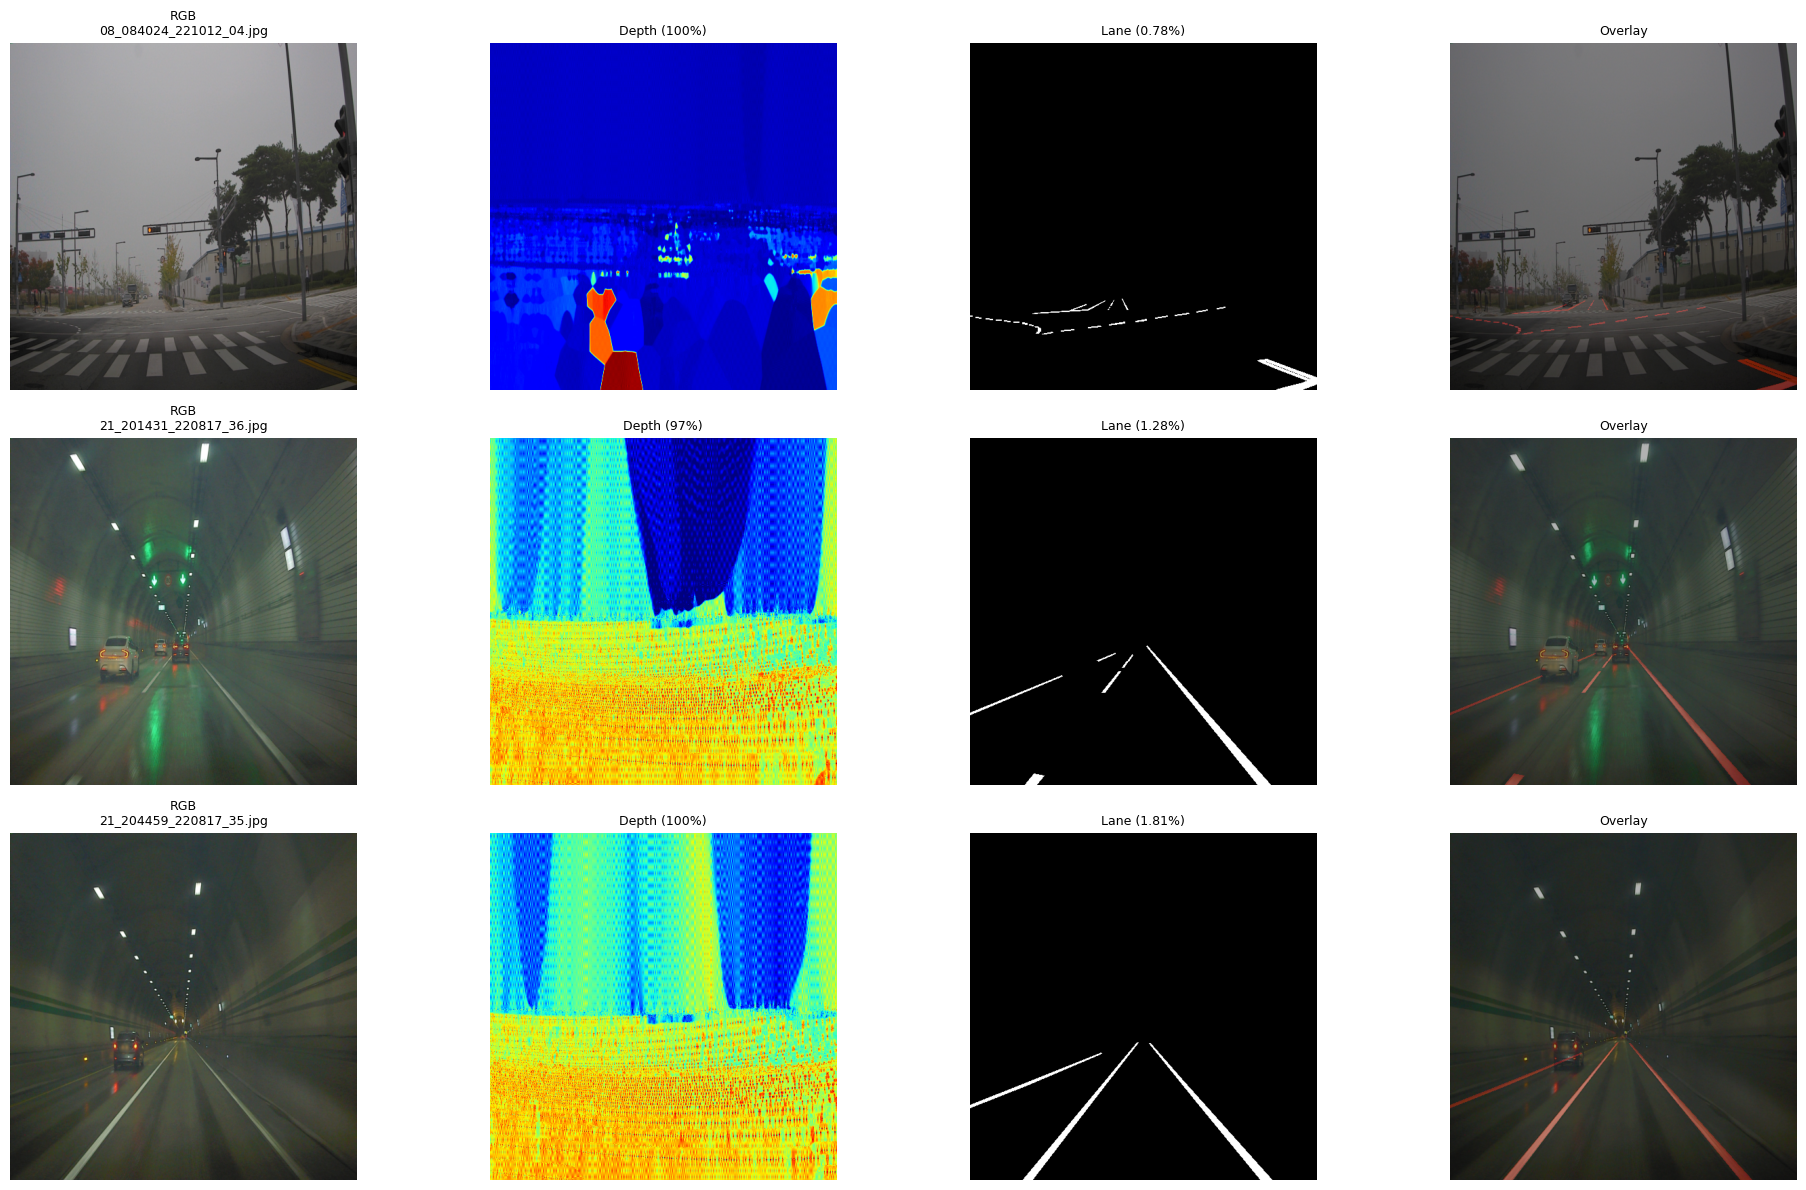

💾 저장: /content/final_verification_with_depth.png

🎉 완료!


In [ ]:
# ============================================
# Dataset 생성 및 검증
# ============================================

print("\n🧪 Dataset 생성 중...\n")

# Step 1: Depth 메모리 로딩
depth_memory_cache = preload_all_depths_to_memory(data_dir / 'depth_cache_512')

# Step 2: Dataset 생성
train_dataset = MultimodalLaneDataset(
    metadata_csv=data_dir / 'train_metadata.csv',
    data_dir=data_dir,
    depth_memory_cache=depth_memory_cache,
    split='train',
    transform=None,  # 검증용
    image_size=(512, 512),
    use_depth=True
)

val_dataset = MultimodalLaneDataset(
    metadata_csv=data_dir / 'val_metadata.csv',
    data_dir=data_dir,
    depth_memory_cache=depth_memory_cache,
    split='val',
    transform=None,
    image_size=(512, 512),
    use_depth=True
)

print(f"\n✅ Dataset 생성 완료!")
print(f"   Train: {len(train_dataset):,}개")
print(f"   Val: {len(val_dataset):,}개")

# 샘플 검증
print("\n🔍 샘플 3개 검증:")
print("-"*70)

for i in range(3):
    sample = train_dataset[i]

    rgb_shape = sample['pixel_values'].shape
    depth_shape = sample['depth'].shape
    label_shape = sample['labels'].shape

    depth_valid = (sample['depth'] > 0).sum().item() / sample['depth'].numel() * 100
    lane_pct = (sample['labels'] == 1).sum().item() / sample['labels'].numel() * 100

    print(f"\nSample {i+1}: {sample['filename']}")
    print(f"  RGB: {rgb_shape}")
    print(f"  Depth: {depth_shape} ({depth_valid:.1f}% valid)")
    print(f"  Lane: {label_shape} ({lane_pct:.2f}% lane)")

# 시각화
print("\n📊 시각화 생성 중...")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(20, 12))

for i in range(3):
    sample = train_dataset[i]

    # RGB
    rgb = sample['pixel_values'].permute(1, 2, 0).numpy()
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(f"RGB\n{sample['filename']}", fontsize=9)
    axes[i, 0].axis('off')

    # Depth
    depth = sample['depth'].squeeze().numpy()
    axes[i, 1].imshow(depth, cmap='jet', vmin=0, vmax=1)
    valid_pct = (depth > 0).sum() / depth.size * 100
    axes[i, 1].set_title(f'Depth ({valid_pct:.0f}%)', fontsize=9)
    axes[i, 1].axis('off')

    # Label
    label = sample['labels'].numpy()
    lane_pct = (label == 1).sum() / label.size * 100
    axes[i, 2].imshow(label, cmap='gray')
    axes[i, 2].set_title(f'Lane ({lane_pct:.2f}%)', fontsize=9)
    axes[i, 2].axis('off')

    # Overlay
    overlay = rgb.copy()
    mask_colored = np.zeros_like(rgb)
    mask_colored[label == 1] = [1, 0, 0]
    overlay = overlay * 0.7 + mask_colored * 0.3
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title('Overlay', fontsize=9)
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('/content/final_verification_with_depth.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 저장: /content/final_verification_with_depth.png")

print("\n" + "="*70)
print("🎉 완료!")
print("="*70)

In [ ]:
# ============================================
# DataLoader 생성 (최적화 버전)
# ============================================

from torch.utils.data import DataLoader

print("\n📦 DataLoader 생성 중...\n")

# Augmentation 적용된 Train Dataset
train_dataset_final = MultimodalLaneDataset(
    metadata_csv=data_dir / 'train_metadata.csv',
    data_dir=data_dir,
    depth_memory_cache=depth_memory_cache,
    split='train',
    transform=get_train_transforms(),
    image_size=(512, 512),
    use_depth=True
)

# Val Dataset (Aug 없음)
val_dataset_final = MultimodalLaneDataset(
    metadata_csv=data_dir / 'val_metadata.csv',
    data_dir=data_dir,
    depth_memory_cache=depth_memory_cache,
    split='val',
    transform=None,
    image_size=(512, 512),
    use_depth=True
)

# ✅ 최적화된 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,  # ✅ 증가
    pin_memory=True,
    prefetch_factor=4,  # ✅ 미리 로드
    persistent_workers=True  # ✅ Worker 재사용
)

val_loader = DataLoader(
    val_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

print(f"✅ DataLoader 생성 완료!")
print(f"   Train batches: {len(train_loader):,} (batch_size={BATCH_SIZE})")
print(f"   Val batches: {len(val_loader):,} (batch_size={BATCH_SIZE})")
print(f"   Total train samples: {len(train_dataset_final):,}")
print(f"   Total val samples: {len(val_dataset_final):,}")

# 샘플 배치 확인
print("\n🔍 샘플 배치 확인...\n")

batch = next(iter(train_loader))

print(f"배치 구조:")
print(f"  pixel_values: {batch['pixel_values'].shape}")
print(f"  depth: {batch['depth'].shape}")
print(f"  labels: {batch['labels'].shape}")

print(f"\n데이터 범위:")
print(f"  RGB: [{batch['pixel_values'].min():.3f}, {batch['pixel_values'].max():.3f}]")
print(f"  Depth: [{batch['depth'].min():.3f}, {batch['depth'].max():.3f}]")
print(f"  Label: [{batch['labels'].min()}, {batch['labels'].max()}]")

# 클래스 분포
lane_ratio = (batch['labels'] == 1).sum().item() / batch['labels'].numel() * 100
print(f"\n배치 내 Lane 비율: {lane_ratio:.2f}%")

print("\n✅ DataLoader 테스트 완료!")


📦 DataLoader 생성 중...

✓ Dataset (train): 6,080 samples
  - Images: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/images
  - Labels: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/lane_labels
✓ Dataset (val): 1,520 samples
  - Images: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/images
  - Labels: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data/lane_labels
✅ DataLoader 생성 완료!
   Train batches: 190 (batch_size=32)
   Val batches: 48 (batch_size=32)
   Total train samples: 6,080
   Total val samples: 1,520

🔍 샘플 배치 확인...

배치 구조:
  pixel_values: torch.Size([32, 3, 512, 512])
  depth: torch.Size([32, 1, 512, 512])
  labels: torch.Size([32, 512, 512])

데이터 범위:
  RGB: [-2.118, 2.640]
  Depth: [-7.292, 1.000]
  Label: [0, 1]

배치 내 Lane 비율: 1.23%

✅ DataLoader 테스트 완료!


In [ ]:
# ============================================
# 1. 모델 정의: Multimodal SegFormer
# ============================================

import torch
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

class MultimodalSegFormerLane(nn.Module):
    """RGB + Depth 입력을 받는 SegFormer"""

    def __init__(self, segformer_model):
        super().__init__()
        self.segformer = segformer_model

        # Depth Encoder
        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # RGB Projection
        self.rgb_proj = nn.Conv2d(3, 32, kernel_size=3, stride=4, padding=1)

        # Fusion Layer
        self.fusion = nn.Sequential(
            nn.Conv2d(32 + 64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1),
        )

    @classmethod
    def from_pretrained(cls, model_name, **kwargs):
        segformer = SegformerForSemanticSegmentation.from_pretrained(
            model_name,
            **kwargs
        )
        return cls(segformer)

    def forward(self, pixel_values, depth):
        B, C, H, W = pixel_values.shape

        # Depth Encoding
        depth_features = self.depth_encoder(depth)

        # RGB Projection
        rgb_features = self.rgb_proj(pixel_values)

        # Depth Resize
        depth_resized = nn.functional.interpolate(
            depth_features,
            size=rgb_features.shape[-2:],
            mode='bilinear',
            align_corners=False
        )

        # Fusion
        fused = torch.cat([rgb_features, depth_resized], dim=1)
        fused = self.fusion(fused)

        # Upsample
        fused_upsampled = nn.functional.interpolate(
            fused,
            size=(H, W),
            mode='bilinear',
            align_corners=False
        )

        # SegFormer Forward
        outputs = self.segformer(fused_upsampled)

        return outputs


print("✅ MultimodalSegFormerLane 클래스 정의 완료!")

✅ MultimodalSegFormerLane 클래스 정의 완료!


In [ ]:
# ============================================
# 2. 모델 로드 및 초기화
# ============================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultimodalSegFormerLane.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=1,
    ignore_mismatched_sizes=True
).to(device)

print(f"✅ 모델 로드 완료 (Device: {device})")

# Loss
pos_weight = torch.tensor([100.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer & Scheduler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=6e-5, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

print(f"✅ Loss: BCEWithLogitsLoss (pos_weight=100.0)")
print(f"✅ Optimizer: AdamW (lr=6e-5)")
print(f"✅ Scheduler: CosineAnnealingLR")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 모델 로드 완료 (Device: cuda)
✅ Loss: BCEWithLogitsLoss (pos_weight=100.0)
✅ Optimizer: AdamW (lr=6e-5)
✅ Scheduler: CosineAnnealingLR


In [ ]:
# ============================================
# 3. Training Functions (Mixed Precision)
# ============================================

from torch.amp import autocast
from torch.cuda.amp import GradScaler
from tqdm import tqdm

scaler = GradScaler()

def train_one_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Train]")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        depth = batch['depth'].to(device)
        labels = batch['labels'].to(device).float()

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(pixel_values, depth)
            logits = outputs.logits

            if logits.shape[-2:] != labels.shape[-2:]:
                logits = nn.functional.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode='bilinear',
                    align_corners=False
                )

            loss = criterion(logits.squeeze(1), labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return {'loss': total_loss / len(loader)}


def validate(model, loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_f1 = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Val]")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            depth = batch['depth'].to(device)
            labels = batch['labels'].to(device).float()

            with autocast(device_type='cuda'):
                outputs = model(pixel_values, depth)
                logits = outputs.logits

                if logits.shape[-2:] != labels.shape[-2:]:
                    logits = nn.functional.interpolate(
                        logits,
                        size=labels.shape[-2:],
                        mode='bilinear',
                        align_corners=False
                    )

                loss = criterion(logits.squeeze(1), labels)

            preds = (torch.sigmoid(logits.squeeze(1)) > 0.5).float()

            # IoU
            intersection = (preds * labels).sum()
            union = preds.sum() + labels.sum() - intersection
            iou = (intersection / (union + 1e-6)).item()

            # F1
            tp = (preds * labels).sum()
            fp = (preds * (1 - labels)).sum()
            fn = ((1 - preds) * labels).sum()
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = (2 * precision * recall / (precision + recall + 1e-6)).item()

            total_loss += loss.item()
            total_iou += iou
            total_f1 += f1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'iou': f'{iou:.4f}'
            })

    return {
        'loss': total_loss / len(loader),
        'lane_iou': total_iou / len(loader),
        'f1': total_f1 / len(loader)
    }


print("✅ Training Functions 정의 완료!")

✅ Training Functions 정의 완료!


/tmp/ipython-input-818044557.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# ============================================
# 4. Checkpoint 저장/로드 함수
# ============================================

from pathlib import Path

checkpoint_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints')
checkpoint_dir.mkdir(parents=True, exist_ok=True)

def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics
    }
    torch.save(checkpoint, checkpoint_dir / filename)

def load_checkpoint(model, optimizer, scheduler, filename):
    checkpoint = torch.load(checkpoint_dir / filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch'], checkpoint['metrics']

print(f"✅ Checkpoint 저장 경로: {checkpoint_dir}")

✅ Checkpoint 저장 경로: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints


In [ ]:
# ============================================
# 5. Training Loop
# ============================================

import numpy as np

num_epochs = 20

print("\n" + "="*70)
print("🚀 학습 시작! (자동 저장 ON)")
print("="*70)

print(f"""
📊 학습 설정:
  - Epochs: {num_epochs}
  - Batch size: 32
  - Learning rate: 6e-5

💾 저장 전략:
  - 매 epoch마다: latest.pth
  - Best IoU: best_model.pth
  - 5 epoch마다: epoch_N.pth

📂 저장 위치:
  {checkpoint_dir}

시작합니다! 🚀
""")

history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'val_f1': []
}

best_iou = 0.0
start_epoch = 0

# Training Loop
for epoch in range(start_epoch, num_epochs):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*70}")

    # Train
    train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_metrics = validate(
        model, val_loader, criterion, device, epoch
    )

    # Scheduler step
    scheduler.step()

    # Logging
    print(f"\n📊 Epoch {epoch+1} 결과:")
    print(f"  Train Loss: {train_metrics['loss']:.4f}")
    print(f"  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  Val IoU: {val_metrics['lane_iou']:.4f}")
    print(f"  Val F1: {val_metrics['f1']:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.2e}")

    # History
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_iou'].append(val_metrics['lane_iou'])
    history['val_f1'].append(val_metrics['f1'])

    # 1. Latest 체크포인트
    save_checkpoint(
        model, optimizer, scheduler, epoch,
        {
            'train_loss': train_metrics['loss'],
            'val_loss': val_metrics['loss'],
            'val_iou': val_metrics['lane_iou'],
            'val_f1': val_metrics['f1'],
            'best_iou': best_iou
        },
        'latest.pth'
    )

    # 2. Best 모델
    if val_metrics['lane_iou'] > best_iou:
        best_iou = val_metrics['lane_iou']

        save_checkpoint(
            model, optimizer, scheduler, epoch,
            {
                'train_loss': train_metrics['loss'],
                'val_loss': val_metrics['loss'],
                'val_iou': val_metrics['lane_iou'],
                'val_f1': val_metrics['f1'],
                'best_iou': best_iou
            },
            'best_model.pth'
        )

        print(f"  🎉 Best model 업데이트! IoU: {best_iou:.4f}")

    # 3. 주기적 저장
    if (epoch + 1) % 5 == 0:
        save_checkpoint(
            model, optimizer, scheduler, epoch,
            {
                'train_loss': train_metrics['loss'],
                'val_loss': val_metrics['loss'],
                'val_iou': val_metrics['lane_iou'],
                'val_f1': val_metrics['f1']
            },
            f'epoch_{epoch+1:02d}.pth'
        )
        print(f"  💾 주기 저장: epoch_{epoch+1:02d}.pth")

print("\n" + "="*70)
print("🎉 학습 완료!")
print("="*70)
print(f"Best Val IoU: {best_iou:.4f}")

# History 저장
import json

history_path = checkpoint_dir / 'training_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n💾 학습 기록 저장: {history_path}")


🚀 학습 시작! (자동 저장 ON)

📊 학습 설정:
  - Epochs: 20
  - Batch size: 32
  - Learning rate: 6e-5

💾 저장 전략:
  - 매 epoch마다: latest.pth
  - Best IoU: best_model.pth
  - 5 epoch마다: epoch_N.pth

📂 저장 위치:
  /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints

시작합니다! 🚀


Epoch 1/20


Epoch 1 [Val]: 100%|██████████| 48/48 [02:58<00:00,  3.73s/it, loss=0.6549, iou=0.0382]



📊 Epoch 1 결과:
  Train Loss: 0.7712
  Val Loss: 0.8033
  Val IoU: 0.0563
  Val F1: 0.1066
  LR: 5.96e-05
  🎉 Best model 업데이트! IoU: 0.0563

Epoch 2/20


Epoch 2 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s, loss=0.4740, iou=0.0665]



📊 Epoch 2 결과:
  Train Loss: 0.4412
  Val Loss: 0.5202
  Val IoU: 0.1009
  Val F1: 0.1831
  LR: 5.86e-05
  🎉 Best model 업데이트! IoU: 0.1009

Epoch 3/20


Epoch 3 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.41it/s, loss=0.3978, iou=0.0985]



📊 Epoch 3 결과:
  Train Loss: 0.3324
  Val Loss: 0.4940
  Val IoU: 0.1219
  Val F1: 0.2172
  LR: 5.68e-05
  🎉 Best model 업데이트! IoU: 0.1219

Epoch 4/20


Epoch 4 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s, loss=0.3375, iou=0.1561]



📊 Epoch 4 결과:
  Train Loss: 0.2726
  Val Loss: 0.3862
  Val IoU: 0.1814
  Val F1: 0.3069
  LR: 5.44e-05
  🎉 Best model 업데이트! IoU: 0.1814

Epoch 5/20


Epoch 5 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s, loss=0.3062, iou=0.1103]



📊 Epoch 5 결과:
  Train Loss: 0.2363
  Val Loss: 0.3547
  Val IoU: 0.1361
  Val F1: 0.2394
  LR: 5.14e-05
  💾 주기 저장: epoch_05.pth

Epoch 6/20


Epoch 6 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.45it/s, loss=0.2731, iou=0.1491]



📊 Epoch 6 결과:
  Train Loss: 0.2165
  Val Loss: 0.3246
  Val IoU: 0.1796
  Val F1: 0.3043
  LR: 4.78e-05

Epoch 7/20


Epoch 7 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.45it/s, loss=0.2556, iou=0.1288]



📊 Epoch 7 결과:
  Train Loss: 0.2010
  Val Loss: 0.3155
  Val IoU: 0.1628
  Val F1: 0.2796
  LR: 4.39e-05

Epoch 8/20


Epoch 8 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s, loss=0.2324, iou=0.1353]



📊 Epoch 8 결과:
  Train Loss: 0.1899
  Val Loss: 0.2837
  Val IoU: 0.1684
  Val F1: 0.2880
  LR: 3.96e-05

Epoch 9/20


Epoch 9 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s, loss=0.2331, iou=0.1266]



📊 Epoch 9 결과:
  Train Loss: 0.1794
  Val Loss: 0.2875
  Val IoU: 0.1541
  Val F1: 0.2668
  LR: 3.51e-05

Epoch 10/20


Epoch 10 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.43it/s, loss=0.1800, iou=0.1853]



📊 Epoch 10 결과:
  Train Loss: 0.1716
  Val Loss: 0.2417
  Val IoU: 0.2133
  Val F1: 0.3513
  LR: 3.05e-05
  🎉 Best model 업데이트! IoU: 0.2133
  💾 주기 저장: epoch_10.pth

Epoch 11/20


Epoch 11 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s, loss=0.1858, iou=0.1600]



📊 Epoch 11 결과:
  Train Loss: 0.1697
  Val Loss: 0.2432
  Val IoU: 0.1853
  Val F1: 0.3122
  LR: 2.59e-05

Epoch 12/20


Epoch 12 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.45it/s, loss=0.1865, iou=0.1590]



📊 Epoch 12 결과:
  Train Loss: 0.1633
  Val Loss: 0.2515
  Val IoU: 0.1865
  Val F1: 0.3140
  LR: 2.14e-05

Epoch 13/20


Epoch 13 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.45it/s, loss=0.1824, iou=0.1587]



📊 Epoch 13 결과:
  Train Loss: 0.1573
  Val Loss: 0.2378
  Val IoU: 0.1928
  Val F1: 0.3230
  LR: 1.71e-05

Epoch 14/20


Epoch 14 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s, loss=0.1891, iou=0.1717]



📊 Epoch 14 결과:
  Train Loss: 0.1566
  Val Loss: 0.2438
  Val IoU: 0.2076
  Val F1: 0.3435
  LR: 1.32e-05

Epoch 15/20


Epoch 15 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, loss=0.1737, iou=0.1909]



📊 Epoch 15 결과:
  Train Loss: 0.1538
  Val Loss: 0.2329
  Val IoU: 0.2119
  Val F1: 0.3494
  LR: 9.64e-06
  💾 주기 저장: epoch_15.pth

Epoch 16/20


Epoch 16 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.49it/s, loss=0.1684, iou=0.1968]



📊 Epoch 16 결과:
  Train Loss: 0.1522
  Val Loss: 0.2303
  Val IoU: 0.2217
  Val F1: 0.3626
  LR: 6.63e-06
  🎉 Best model 업데이트! IoU: 0.2217

Epoch 17/20


Epoch 17 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.44it/s, loss=0.1649, iou=0.1931]



📊 Epoch 17 결과:
  Train Loss: 0.1503
  Val Loss: 0.2233
  Val IoU: 0.2193
  Val F1: 0.3594
  LR: 4.22e-06

Epoch 18/20


Epoch 18 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.50it/s, loss=0.1831, iou=0.1656]



📊 Epoch 18 결과:
  Train Loss: 0.1490
  Val Loss: 0.2365
  Val IoU: 0.1971
  Val F1: 0.3290
  LR: 2.44e-06

Epoch 19/20


Epoch 19 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.48it/s, loss=0.1657, iou=0.1974]



📊 Epoch 19 결과:
  Train Loss: 0.1483
  Val Loss: 0.2190
  Val IoU: 0.2197
  Val F1: 0.3599
  LR: 1.36e-06

Epoch 20/20


Epoch 20 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.48it/s, loss=0.1647, iou=0.1952]



📊 Epoch 20 결과:
  Train Loss: 0.1481
  Val Loss: 0.2183
  Val IoU: 0.2178
  Val F1: 0.3575
  LR: 1.00e-06
  💾 주기 저장: epoch_20.pth

🎉 학습 완료!
Best Val IoU: 0.2217

💾 학습 기록 저장: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints/training_history.json


✅ 학습 기록 로드 완료!
   Total Epochs: 20

✅ 전체 시각화 저장: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints/training_results_epoch1-20.png


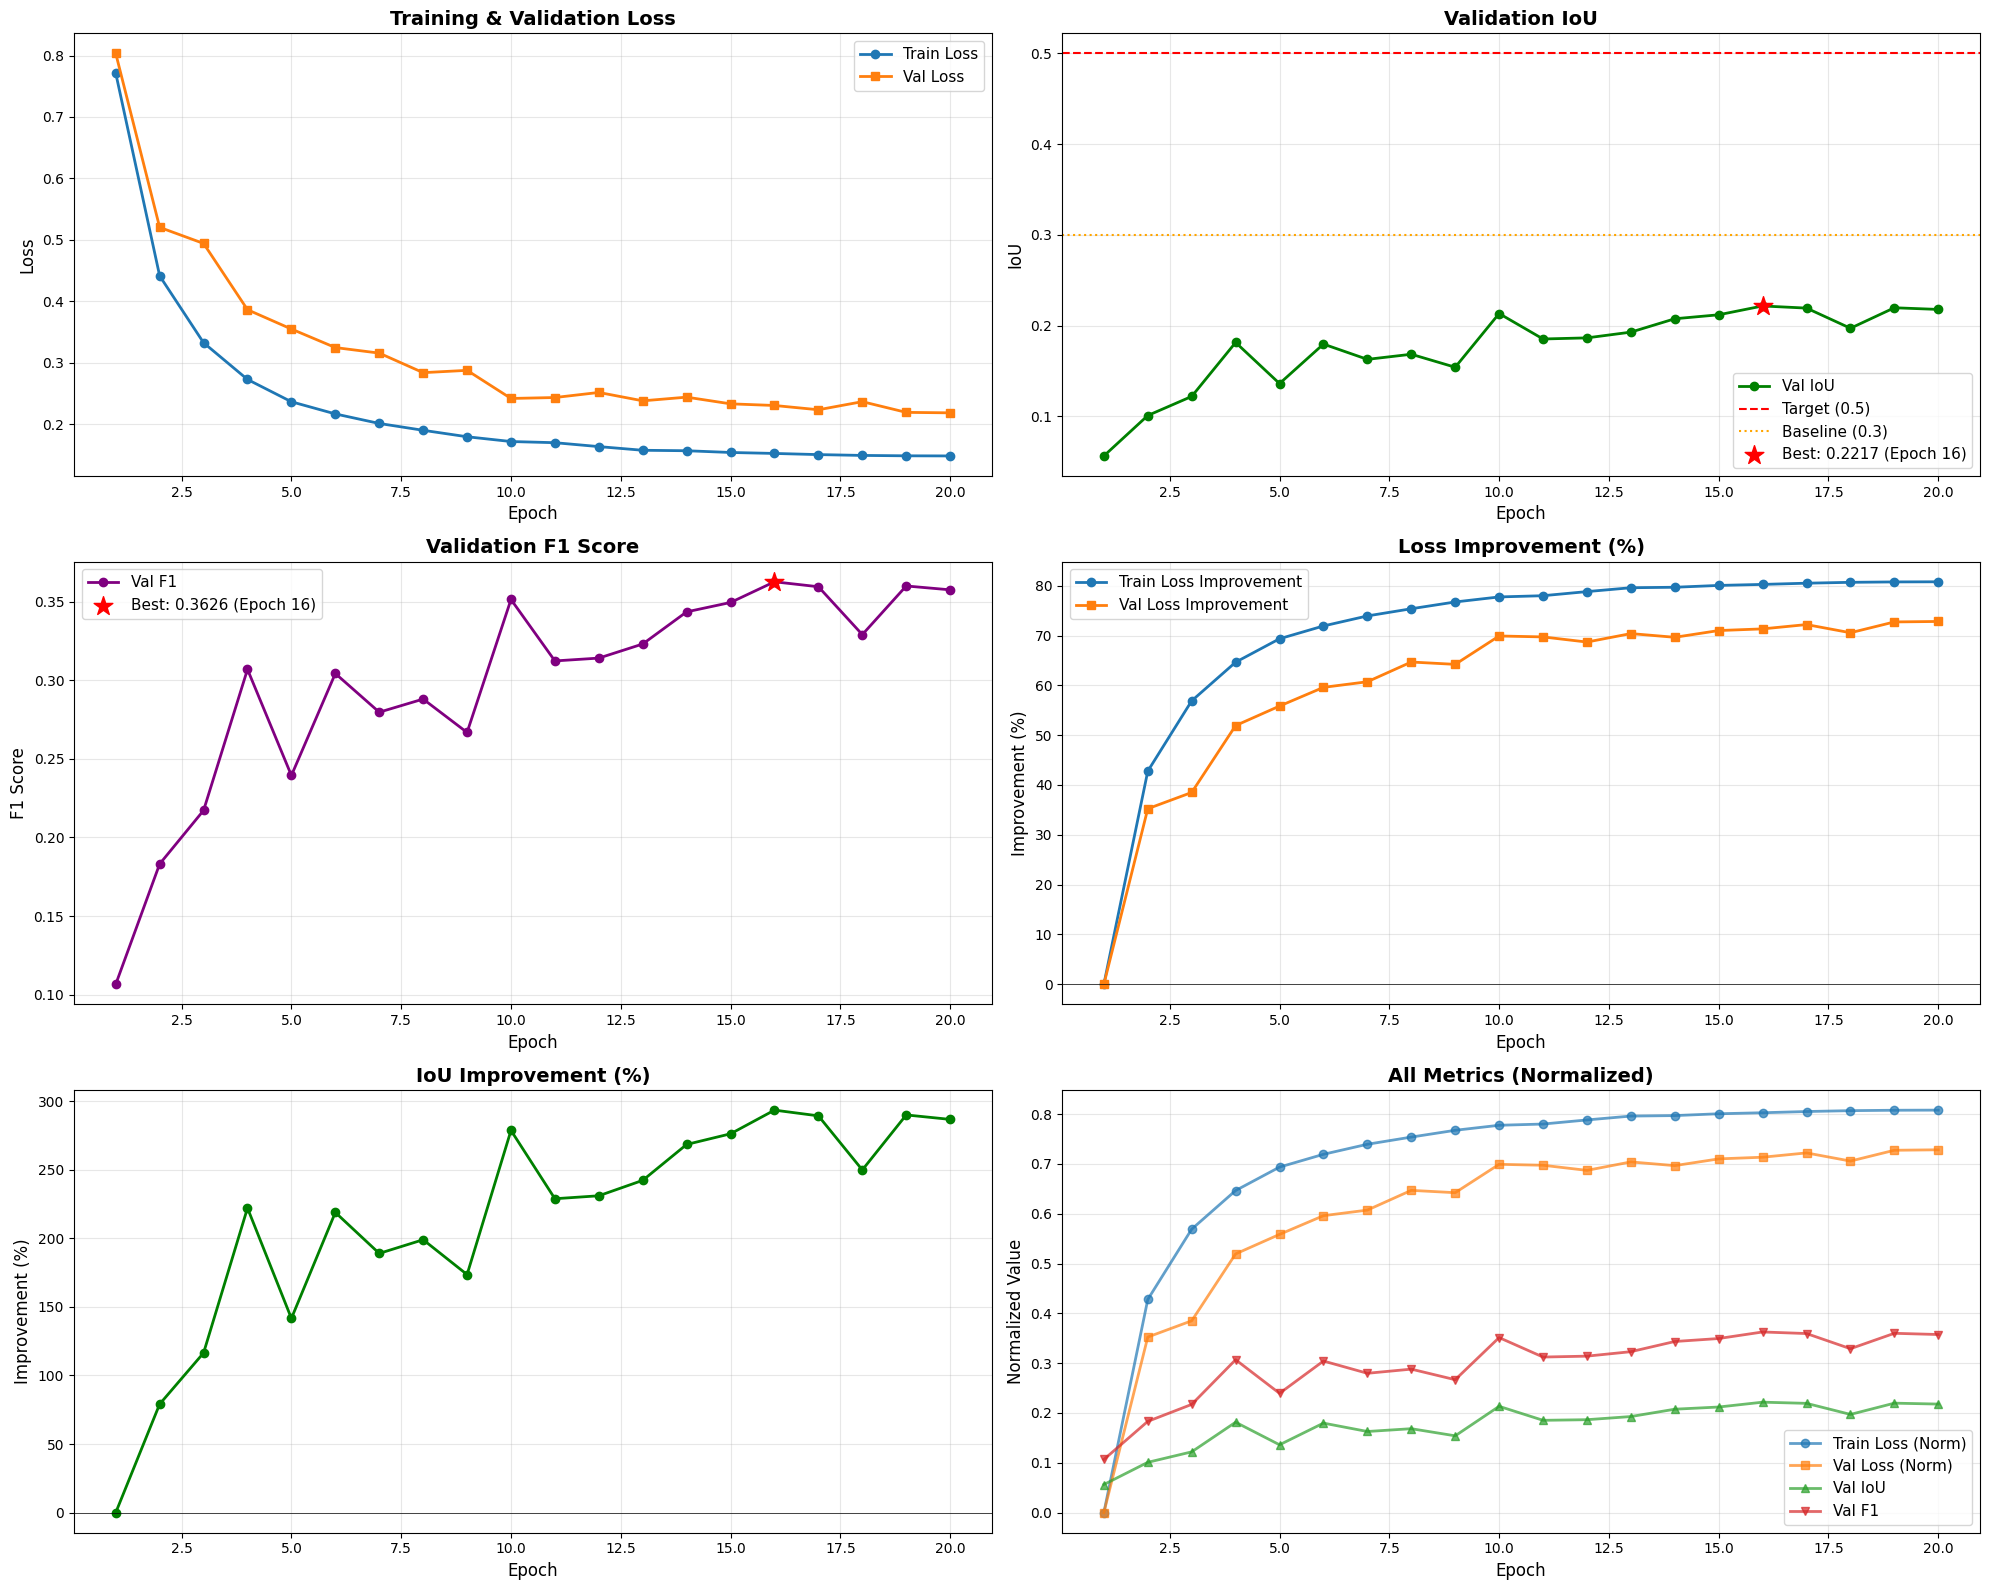


📊 Epoch 1~20 학습 결과 요약

🎯 최종 성능 (Epoch 20):
  - Train Loss: 0.1481
  - Val Loss: 0.2183
  - Val IoU: 0.2178
  - Val F1: 0.3575

🏆 최고 성능:
  - Best IoU: 0.2217 (Epoch 16)
  - Best F1: 0.3626 (Epoch 16)
  - Lowest Val Loss: 0.2183 (Epoch 20)

📈 개선도:
  - Train Loss: 0.7712 → 0.1481 (80.8% ↓)
  - Val Loss: 0.8033 → 0.2183 (72.8% ↓)
  - Val IoU: 0.0563 → 0.2178 (286.6% ↑)
  - Val F1: 0.1066 → 0.3575 (235.3% ↑)

🔍 학습 안정성:
  - IoU 표준편차: 0.0433
  - F1 표준편차: 0.0657
  - Val Loss 표준편차: 0.1403


📋 Epoch별 상세 결과
 Epoch |  Train Loss |  Val Loss |  Val IoU |  Val F1
----------------------------------------------------------------------
     1 |      0.7712 |    0.8033 |   0.0563 |  0.1066
     2 |      0.4412 |    0.5202 |   0.1009 |  0.1831
     3 |      0.3324 |    0.4940 |   0.1219 |  0.2172
     4 |      0.2726 |    0.3862 |   0.1814 |  0.3069
     5 |      0.2363 |    0.3547 |   0.1361 |  0.2394
     6 |      0.2165 |    0.3246 |   0.1796 |  0.3043
     7 |      0.2010 |    0.3155 |   0.1628 |  0

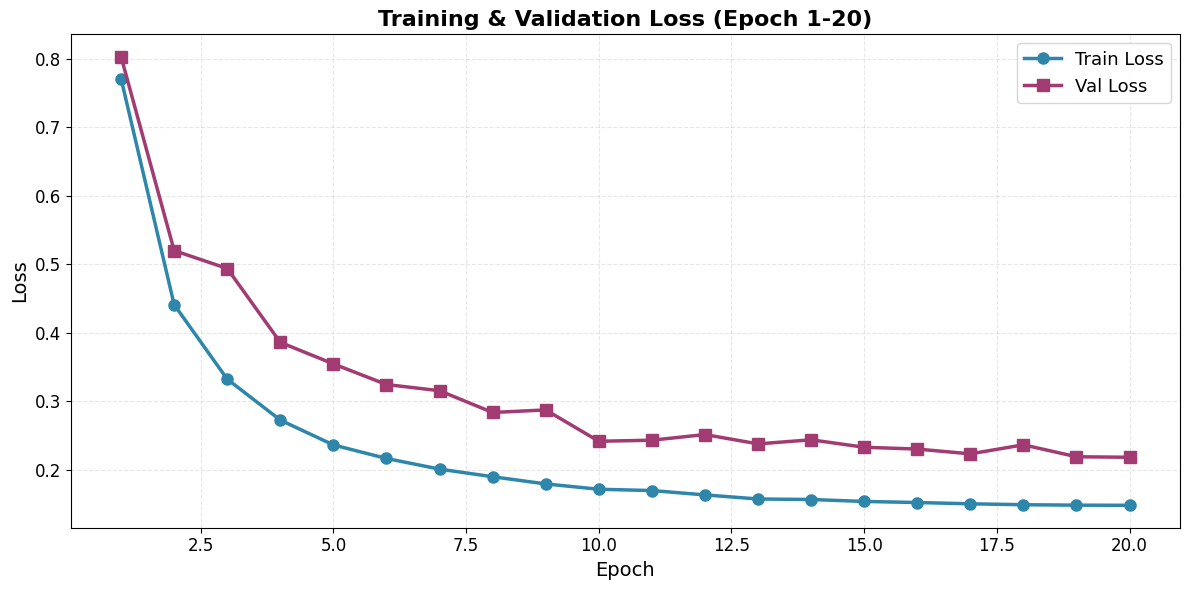

✅ 메트릭 곡선 저장: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints / 'metrics_curve_epoch1-20.png'


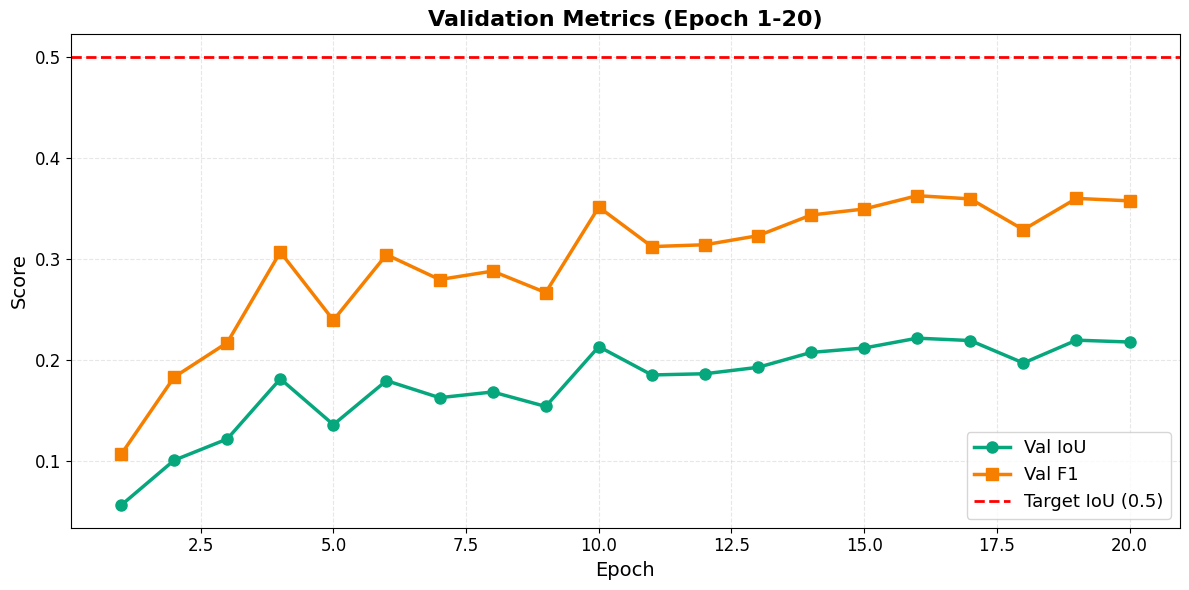

✅ Best vs Final 비교 저장: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints / 'best_vs_final_epoch1-20.png'


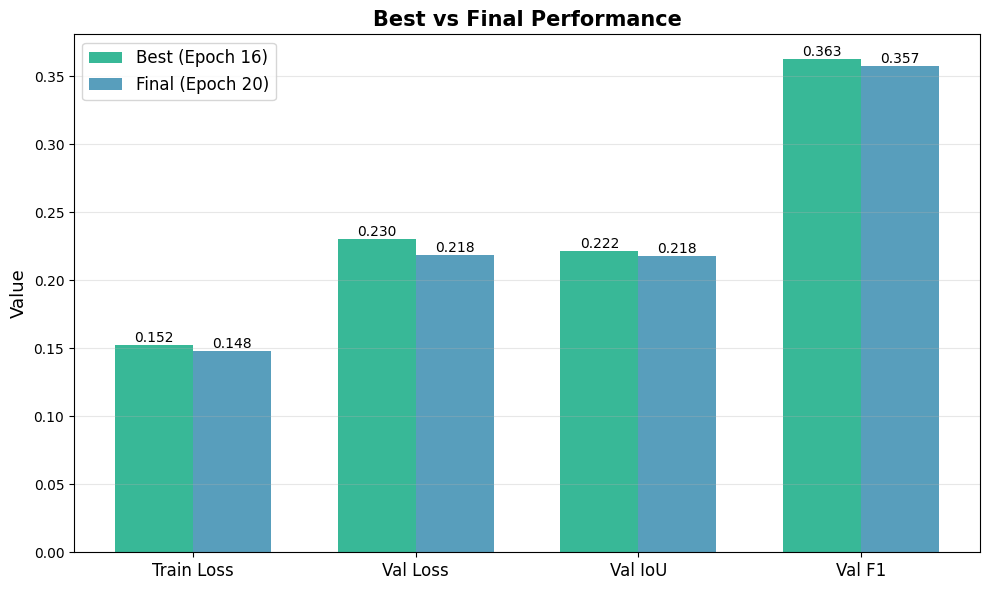


✅ 모든 시각화 완료!


In [ ]:
# ============================================
# Epoch 1~20 학습 결과 시각화
# ============================================

import matplotlib.pyplot as plt
import json
from pathlib import Path
import numpy as np

checkpoint_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints')

# ============================================
# 1. History 로드
# ============================================

history_path = checkpoint_dir / 'training_history.json'

with open(history_path, 'r') as f:
    history = json.load(f)

print("✅ 학습 기록 로드 완료!")
print(f"   Total Epochs: {len(history['train_loss'])}")

# ============================================
# 2. 통합 시각화 (4x2 그리드)
# ============================================

fig = plt.figure(figsize=(20, 16))
epochs = range(1, len(history['train_loss']) + 1)

# 2-1. Train & Val Loss
ax1 = plt.subplot(3, 2, 1)
ax1.plot(epochs, history['train_loss'], marker='o', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], marker='s', label='Val Loss', linewidth=2)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2-2. Val IoU
ax2 = plt.subplot(3, 2, 2)
ax2.plot(epochs, history['val_iou'], marker='o', color='green', linewidth=2, label='Val IoU')
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='Target (0.5)')
ax2.axhline(y=0.3, color='orange', linestyle=':', linewidth=1.5, label='Baseline (0.3)')
best_iou_idx = np.argmax(history['val_iou'])
best_iou = history['val_iou'][best_iou_idx]
ax2.scatter([best_iou_idx + 1], [best_iou], color='red', s=200, zorder=5, marker='*',
            label=f'Best: {best_iou:.4f} (Epoch {best_iou_idx + 1})')
ax2.set_title('Validation IoU', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('IoU', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 2-3. Val F1 Score
ax3 = plt.subplot(3, 2, 3)
ax3.plot(epochs, history['val_f1'], marker='o', color='purple', linewidth=2, label='Val F1')
best_f1_idx = np.argmax(history['val_f1'])
best_f1 = history['val_f1'][best_f1_idx]
ax3.scatter([best_f1_idx + 1], [best_f1], color='red', s=200, zorder=5, marker='*',
            label=f'Best: {best_f1:.4f} (Epoch {best_f1_idx + 1})')
ax3.set_title('Validation F1 Score', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('F1 Score', fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 2-4. Loss 개선률
ax4 = plt.subplot(3, 2, 4)
train_loss_improvement = [(history['train_loss'][0] - l) / history['train_loss'][0] * 100
                          for l in history['train_loss']]
val_loss_improvement = [(history['val_loss'][0] - l) / history['val_loss'][0] * 100
                        for l in history['val_loss']]
ax4.plot(epochs, train_loss_improvement, marker='o', label='Train Loss Improvement', linewidth=2)
ax4.plot(epochs, val_loss_improvement, marker='s', label='Val Loss Improvement', linewidth=2)
ax4.set_title('Loss Improvement (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Improvement (%)', fontsize=12)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 2-5. IoU 개선률
ax5 = plt.subplot(3, 2, 5)
iou_improvement = [(i - history['val_iou'][0]) / (history['val_iou'][0] + 1e-8) * 100
                   for i in history['val_iou']]
ax5.plot(epochs, iou_improvement, marker='o', color='green', linewidth=2)
ax5.set_title('IoU Improvement (%)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('Improvement (%)', fontsize=12)
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 2-6. 전체 메트릭 비교 (정규화)
ax6 = plt.subplot(3, 2, 6)
# 0-1로 정규화
norm_train_loss = [(1 - (l / max(history['train_loss']))) for l in history['train_loss']]
norm_val_loss = [(1 - (l / max(history['val_loss']))) for l in history['val_loss']]
norm_iou = history['val_iou']
norm_f1 = history['val_f1']

ax6.plot(epochs, norm_train_loss, marker='o', label='Train Loss (Norm)', linewidth=2, alpha=0.7)
ax6.plot(epochs, norm_val_loss, marker='s', label='Val Loss (Norm)', linewidth=2, alpha=0.7)
ax6.plot(epochs, norm_iou, marker='^', label='Val IoU', linewidth=2, alpha=0.7)
ax6.plot(epochs, norm_f1, marker='v', label='Val F1', linewidth=2, alpha=0.7)
ax6.set_title('All Metrics (Normalized)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Epoch', fontsize=12)
ax6.set_ylabel('Normalized Value', fontsize=12)
ax6.legend(fontsize=11)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_results_epoch1-20.png', dpi=300, bbox_inches='tight')
print(f"\n✅ 전체 시각화 저장: {checkpoint_dir / 'training_results_epoch1-20.png'}")
plt.show()


# ============================================
# 3. 상세 통계 출력
# ============================================

print("\n" + "="*70)
print("📊 Epoch 1~20 학습 결과 요약")
print("="*70)

print(f"""
🎯 최종 성능 (Epoch 20):
  - Train Loss: {history['train_loss'][-1]:.4f}
  - Val Loss: {history['val_loss'][-1]:.4f}
  - Val IoU: {history['val_iou'][-1]:.4f}
  - Val F1: {history['val_f1'][-1]:.4f}

🏆 최고 성능:
  - Best IoU: {max(history['val_iou']):.4f} (Epoch {np.argmax(history['val_iou']) + 1})
  - Best F1: {max(history['val_f1']):.4f} (Epoch {np.argmax(history['val_f1']) + 1})
  - Lowest Val Loss: {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss']) + 1})

📈 개선도:
  - Train Loss: {history['train_loss'][0]:.4f} → {history['train_loss'][-1]:.4f} ({train_loss_improvement[-1]:.1f}% ↓)
  - Val Loss: {history['val_loss'][0]:.4f} → {history['val_loss'][-1]:.4f} ({val_loss_improvement[-1]:.1f}% ↓)
  - Val IoU: {history['val_iou'][0]:.4f} → {history['val_iou'][-1]:.4f} ({iou_improvement[-1]:.1f}% ↑)
  - Val F1: {history['val_f1'][0]:.4f} → {history['val_f1'][-1]:.4f} ({(history['val_f1'][-1] - history['val_f1'][0]) / (history['val_f1'][0] + 1e-8) * 100:.1f}% ↑)

🔍 학습 안정성:
  - IoU 표준편차: {np.std(history['val_iou']):.4f}
  - F1 표준편차: {np.std(history['val_f1']):.4f}
  - Val Loss 표준편차: {np.std(history['val_loss']):.4f}
""")

# ============================================
# 4. Epoch별 상세 표
# ============================================

print("\n" + "="*70)
print("📋 Epoch별 상세 결과")
print("="*70)
print(f"{'Epoch':>6} | {'Train Loss':>11} | {'Val Loss':>9} | {'Val IoU':>8} | {'Val F1':>7}")
print("-" * 70)

for i, epoch in enumerate(epochs):
    marker = ""
    if i == np.argmax(history['val_iou']):
        marker = " 🏆 (Best IoU)"
    elif i == np.argmax(history['val_f1']):
        marker = " ⭐ (Best F1)"

    print(f"{epoch:6d} | {history['train_loss'][i]:11.4f} | {history['val_loss'][i]:9.4f} | "
          f"{history['val_iou'][i]:8.4f} | {history['val_f1'][i]:7.4f}{marker}")


# ============================================
# 5. 개별 메트릭 그래프 (고해상도)
# ============================================

# 5-1. Loss만 따로
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(epochs, history['train_loss'], marker='o', linewidth=2.5,
        label='Train Loss', color='#2E86AB', markersize=8)
ax.plot(epochs, history['val_loss'], marker='s', linewidth=2.5,
        label='Val Loss', color='#A23B72', markersize=8)
ax.set_title('Training & Validation Loss (Epoch 1-20)', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=13, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(checkpoint_dir / 'loss_curve_epoch1-20.png', dpi=300, bbox_inches='tight')
print(f"✅ Loss 곡선 저장: {checkpoint_dir} / 'loss_curve_epoch1-20.png'")
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(epochs, history['val_iou'], marker='o', linewidth=2.5,
        label='Val IoU', color='#06A77D', markersize=8)
ax.plot(epochs, history['val_f1'], marker='s', linewidth=2.5,
        label='Val F1', color='#F77F00', markersize=8)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Target IoU (0.5)')
ax.set_title('Validation Metrics (Epoch 1-20)', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.legend(fontsize=13, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(checkpoint_dir / 'metrics_curve_epoch1-20.png', dpi=300, bbox_inches='tight')
print(f"✅ 메트릭 곡선 저장: {checkpoint_dir} / 'metrics_curve_epoch1-20.png'")
plt.show()


best_epoch = np.argmax(history['val_iou']) + 1
final_epoch = len(history['val_iou'])

fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Train Loss', 'Val Loss', 'Val IoU', 'Val F1']
best_values = [
    history['train_loss'][best_epoch - 1],
    history['val_loss'][best_epoch - 1],
    history['val_iou'][best_epoch - 1],
    history['val_f1'][best_epoch - 1]
]
final_values = [
    history['train_loss'][-1],
    history['val_loss'][-1],
    history['val_iou'][-1],
    history['val_f1'][-1]
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, best_values, width, label=f'Best (Epoch {best_epoch})',
               color='#06A77D', alpha=0.8)
bars2 = ax.bar(x + width/2, final_values, width, label=f'Final (Epoch {final_epoch})',
               color='#2E86AB', alpha=0.8)

ax.set_ylabel('Value', fontsize=13)
ax.set_title('Best vs Final Performance', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'best_vs_final_epoch1-20.png', dpi=300, bbox_inches='tight')
print(f"✅ Best vs Final 비교 저장: {checkpoint_dir} / 'best_vs_final_epoch1-20.png'")
plt.show()

print("\n" + "="*70)
print("✅ 모든 시각화 완료!")
print("="*70)


🔄 추가 학습 준비 (Epoch 21~40)


/tmp/ipython-input-2019666718.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



✅ 체크포인트 로드 완료!
   - Loaded Epoch: 16
   - Best IoU: 0.2217
   - Val Loss: 0.2303

✅ Loss: Focal Loss (alpha=0.25, gamma=2.0)

✅ Optimizer: AdamW
   - Backbone LR: 3e-5
   - Fusion LR: 5e-4 (새로운 레이어)
✅ Scheduler: CosineAnnealingLR (T_max=20)

🚀 추가 학습 시작!

📊 학습 설정:
  - Epochs: 21~40 (총 20 epoch 추가)
  - Batch size: 32
  - Backbone LR: 3e-5
  - Fusion LR: 5e-4
  - Loss: Focal Loss

💾 저장 전략:
  - 매 epoch마다: latest_v2.pth
  - Best IoU: best_model_v2.pth
  - 5 epoch마다: epoch_N.pth

📂 저장 위치:
  /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints

시작합니다! 🚀


Epoch 21/40


Epoch 21 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.49it/s, loss=0.0010, iou=0.5302]



📊 Epoch 21 결과:
  Train Loss: 0.0016
  Val Loss: 0.0013
  Val IoU: 0.5470
  Val F1: 0.7062
  LR (Backbone): 2.98e-05
  LR (Fusion): 4.97e-04
  🎉 Best model 업데이트! IoU: 0.5470

Epoch 22/40


Epoch 22 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.48it/s, loss=0.0010, iou=0.5313]



📊 Epoch 22 결과:
  Train Loss: 0.0010
  Val Loss: 0.0013
  Val IoU: 0.5388
  Val F1: 0.6992
  LR (Backbone): 2.94e-05
  LR (Fusion): 4.88e-04

Epoch 23/40


Epoch 23 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s, loss=0.0009, iou=0.5513]



📊 Epoch 23 결과:
  Train Loss: 0.0010
  Val Loss: 0.0013
  Val IoU: 0.5540
  Val F1: 0.7120
  LR (Backbone): 2.86e-05
  LR (Fusion): 4.73e-04
  🎉 Best model 업데이트! IoU: 0.5540

Epoch 24/40


Epoch 24 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.51it/s, loss=0.0009, iou=0.5492]



📊 Epoch 24 결과:
  Train Loss: 0.0010
  Val Loss: 0.0012
  Val IoU: 0.5543
  Val F1: 0.7122
  LR (Backbone): 2.76e-05
  LR (Fusion): 4.53e-04
  🎉 Best model 업데이트! IoU: 0.5543

Epoch 25/40


Epoch 25 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s, loss=0.0010, iou=0.5381]



📊 Epoch 25 결과:
  Train Loss: 0.0010
  Val Loss: 0.0013
  Val IoU: 0.5477
  Val F1: 0.7067
  LR (Backbone): 2.63e-05
  LR (Fusion): 4.28e-04
  💾 주기 저장: epoch_25.pth

Epoch 26/40


Epoch 26 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.49it/s, loss=0.0009, iou=0.5776]



📊 Epoch 26 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5783
  Val F1: 0.7318
  LR (Backbone): 2.48e-05
  LR (Fusion): 3.98e-04
  🎉 Best model 업데이트! IoU: 0.5783

Epoch 27/40


Epoch 27 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s, loss=0.0009, iou=0.5502]



📊 Epoch 27 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5642
  Val F1: 0.7204
  LR (Backbone): 2.32e-05
  LR (Fusion): 3.65e-04

Epoch 28/40


Epoch 28 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s, loss=0.0009, iou=0.5704]



📊 Epoch 28 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5866
  Val F1: 0.7386
  LR (Backbone): 2.14e-05
  LR (Fusion): 3.29e-04
  🎉 Best model 업데이트! IoU: 0.5866

Epoch 29/40


Epoch 29 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s, loss=0.0009, iou=0.5449]



📊 Epoch 29 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5581
  Val F1: 0.7153
  LR (Backbone): 1.95e-05
  LR (Fusion): 2.91e-04

Epoch 30/40


Epoch 30 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.44it/s, loss=0.0009, iou=0.5468]



📊 Epoch 30 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5580
  Val F1: 0.7152
  LR (Backbone): 1.75e-05
  LR (Fusion): 2.53e-04
  💾 주기 저장: epoch_30.pth

Epoch 31/40


Epoch 31 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s, loss=0.0009, iou=0.5547]



📊 Epoch 31 결과:
  Train Loss: 0.0009
  Val Loss: 0.0013
  Val IoU: 0.5616
  Val F1: 0.7182
  LR (Backbone): 1.55e-05
  LR (Fusion): 2.14e-04

Epoch 32/40


Epoch 32 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.49it/s, loss=0.0009, iou=0.5676]



📊 Epoch 32 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5746
  Val F1: 0.7288
  LR (Backbone): 1.36e-05
  LR (Fusion): 1.76e-04

Epoch 33/40


Epoch 33 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.45it/s, loss=0.0009, iou=0.5537]



📊 Epoch 33 결과:
  Train Loss: 0.0009
  Val Loss: 0.0013
  Val IoU: 0.5610
  Val F1: 0.7177
  LR (Backbone): 1.18e-05
  LR (Fusion): 1.40e-04

Epoch 34/40


Epoch 34 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.39it/s, loss=0.0009, iou=0.5565]



📊 Epoch 34 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5681
  Val F1: 0.7235
  LR (Backbone): 1.02e-05
  LR (Fusion): 1.07e-04

Epoch 35/40


Epoch 35 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s, loss=0.0009, iou=0.5552]



📊 Epoch 35 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5640
  Val F1: 0.7201
  LR (Backbone): 8.66e-06
  LR (Fusion): 7.75e-05
  💾 주기 저장: epoch_35.pth

Epoch 36/40


Epoch 36 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s, loss=0.0009, iou=0.5690]



📊 Epoch 36 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5830
  Val F1: 0.7356
  LR (Backbone): 7.39e-06
  LR (Fusion): 5.23e-05

Epoch 37/40


Epoch 37 [Val]: 100%|██████████| 48/48 [00:14<00:00,  3.41it/s, loss=0.0009, iou=0.5556]



📊 Epoch 37 결과:
  Train Loss: 0.0009
  Val Loss: 0.0012
  Val IoU: 0.5668
  Val F1: 0.7224
  LR (Backbone): 6.36e-06
  LR (Fusion): 3.20e-05

Epoch 38/40


Epoch 38 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.43it/s, loss=0.0009, iou=0.5753]



📊 Epoch 38 결과:
  Train Loss: 0.0009
  Val Loss: 0.0011
  Val IoU: 0.5851
  Val F1: 0.7373
  LR (Backbone): 5.61e-06
  LR (Fusion): 1.71e-05

Epoch 39/40


Epoch 39 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s, loss=0.0009, iou=0.5693]



📊 Epoch 39 결과:
  Train Loss: 0.0008
  Val Loss: 0.0012
  Val IoU: 0.5780
  Val F1: 0.7316
  LR (Backbone): 5.15e-06
  LR (Fusion): 8.05e-06

Epoch 40/40


Epoch 40 [Val]: 100%|██████████| 48/48 [00:13<00:00,  3.51it/s, loss=0.0009, iou=0.5716]



📊 Epoch 40 결과:
  Train Loss: 0.0008
  Val Loss: 0.0012
  Val IoU: 0.5808
  Val F1: 0.7338
  LR (Backbone): 5.00e-06
  LR (Fusion): 5.00e-06
  💾 주기 저장: epoch_40.pth

🎉 추가 학습 완료!
Previous Best IoU: 0.2217
New Best IoU: 0.5866
Improvement: 0.3650

💾 학습 기록 저장: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints/training_history_v2.json

📊 학습 곡선 저장: /content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints/training_progress_v2.png


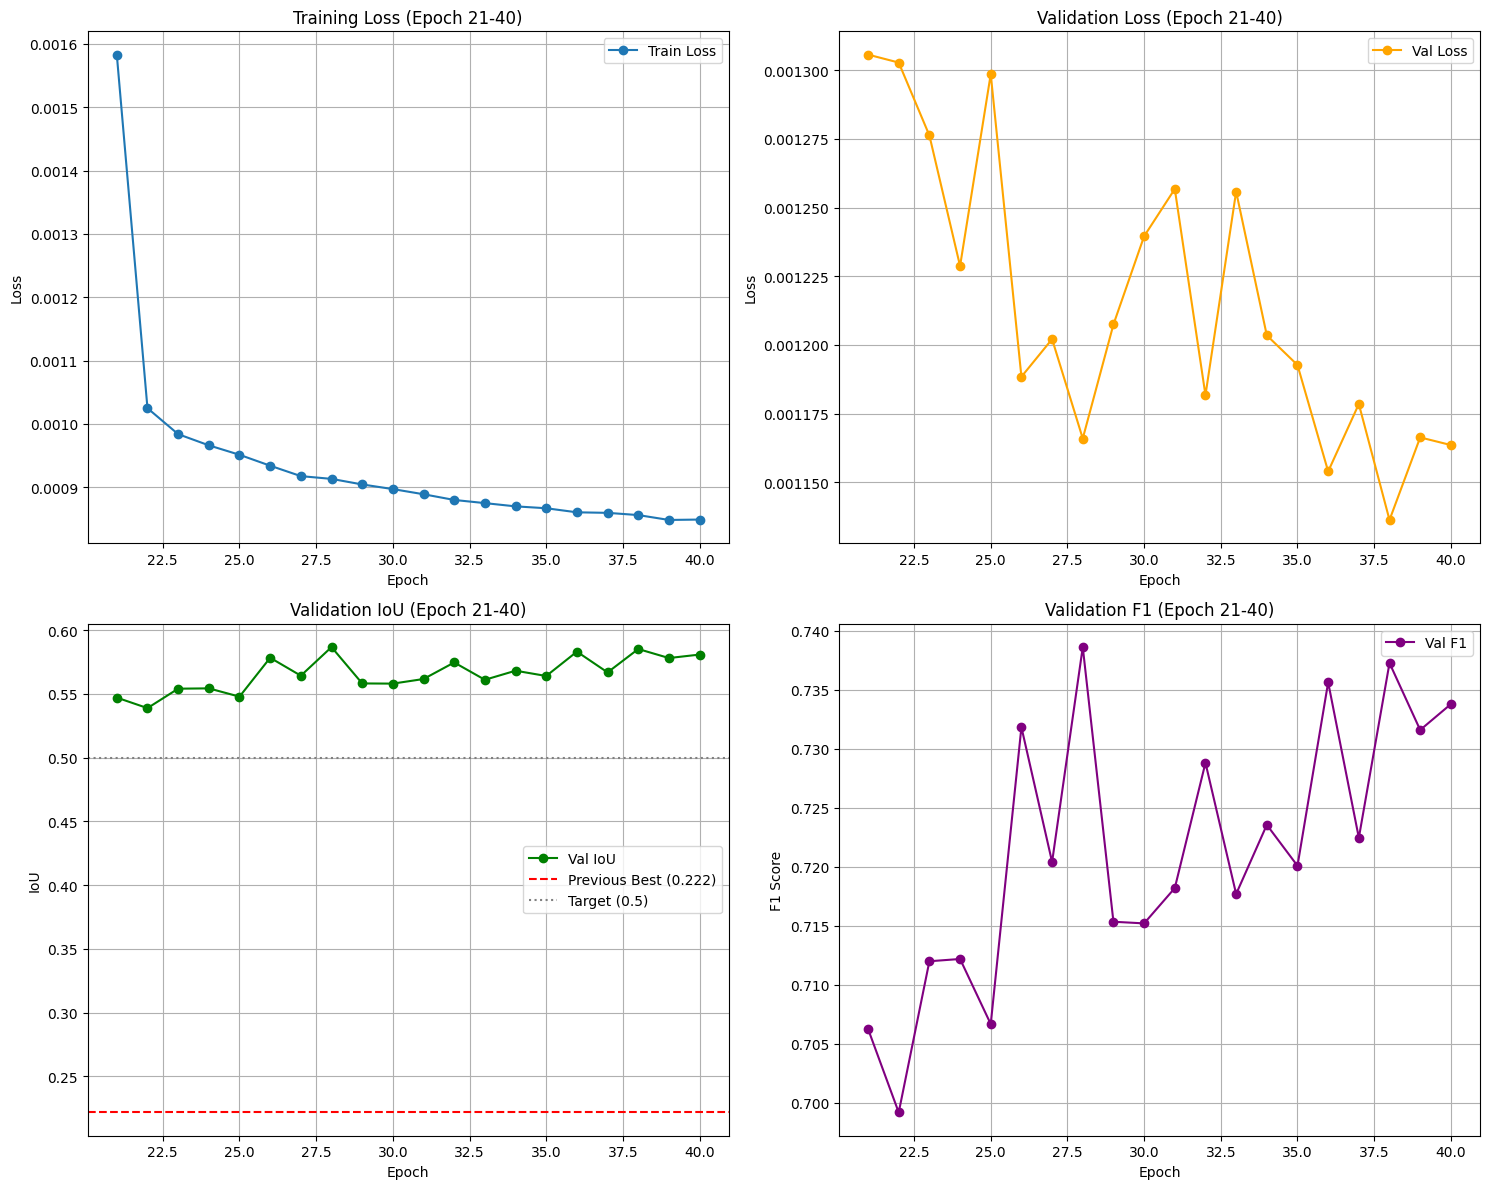

In [ ]:
# ============================================
# 추가 학습 설정 (Epoch 21~40)
# ============================================

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from tqdm import tqdm
from pathlib import Path
import json

print("\n" + "="*70)
print("🔄 추가 학습 준비 (Epoch 21~40)")
print("="*70)

# ============================================
# 1. 체크포인트 로드
# ============================================

checkpoint_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Checkpoints')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Best 모델 로드
checkpoint = torch.load(checkpoint_dir / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"\n✅ 체크포인트 로드 완료!")
print(f"   - Loaded Epoch: {checkpoint['epoch'] + 1}")
print(f"   - Best IoU: {checkpoint['metrics']['best_iou']:.4f}")
print(f"   - Val Loss: {checkpoint['metrics']['val_loss']:.4f}")

previous_best_iou = checkpoint['metrics']['best_iou']

# ============================================
# 2. Focal Loss 적용
# ============================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

criterion = FocalLoss(alpha=0.25, gamma=2.0).to(device)

print(f"\n✅ Loss: Focal Loss (alpha=0.25, gamma=2.0)")

# ============================================
# 3. Differential Learning Rate
# ============================================

# 파라미터 그룹 분리
backbone_params = []
fusion_params = []

for name, param in model.named_parameters():
    if 'depth_encoder' in name or 'fusion' in name or 'rgb_proj' in name:
        fusion_params.append(param)
    else:
        backbone_params.append(param)

# Optimizer
optimizer = AdamW([
    {'params': backbone_params, 'lr': 3e-5, 'weight_decay': 0.01},  # Backbone: 낮은 LR
    {'params': fusion_params, 'lr': 5e-4, 'weight_decay': 0.01}      # Fusion: 높은 LR
])

print(f"\n✅ Optimizer: AdamW")
print(f"   - Backbone LR: 3e-5")
print(f"   - Fusion LR: 5e-4 (새로운 레이어)")

# Scheduler
additional_epochs = 20
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=additional_epochs,
    eta_min=5e-6
)

print(f"✅ Scheduler: CosineAnnealingLR (T_max={additional_epochs})")

# ============================================
# 4. Training Functions
# ============================================

scaler = GradScaler()

def train_one_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Train]")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        depth = batch['depth'].to(device)
        labels = batch['labels'].to(device).float()

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(pixel_values, depth)
            logits = outputs.logits

            if logits.shape[-2:] != labels.shape[-2:]:
                logits = nn.functional.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode='bilinear',
                    align_corners=False
                )

            loss = criterion(logits.squeeze(1), labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return {'loss': total_loss / len(loader)}


def validate(model, loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_f1 = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Val]")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            depth = batch['depth'].to(device)
            labels = batch['labels'].to(device).float()

            with autocast(device_type='cuda'):
                outputs = model(pixel_values, depth)
                logits = outputs.logits

                if logits.shape[-2:] != labels.shape[-2:]:
                    logits = nn.functional.interpolate(
                        logits,
                        size=labels.shape[-2:],
                        mode='bilinear',
                        align_corners=False
                    )

                loss = criterion(logits.squeeze(1), labels)

            preds = (torch.sigmoid(logits.squeeze(1)) > 0.5).float()

            # IoU
            intersection = (preds * labels).sum()
            union = preds.sum() + labels.sum() - intersection
            iou = (intersection / (union + 1e-6)).item()

            # F1
            tp = (preds * labels).sum()
            fp = (preds * (1 - labels)).sum()
            fn = ((1 - preds) * labels).sum()
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = (2 * precision * recall / (precision + recall + 1e-6)).item()

            total_loss += loss.item()
            total_iou += iou
            total_f1 += f1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'iou': f'{iou:.4f}'
            })

    return {
        'loss': total_loss / len(loader),
        'lane_iou': total_iou / len(loader),
        'f1': total_f1 / len(loader)
    }


# ============================================
# 5. Checkpoint 저장 함수
# ============================================

def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics
    }
    torch.save(checkpoint, checkpoint_dir / filename)


# ============================================
# 6. 추가 학습 Loop (Epoch 21~40)
# ============================================

print("\n" + "="*70)
print("🚀 추가 학습 시작!")
print("="*70)

print(f"""
📊 학습 설정:
  - Epochs: 21~40 (총 20 epoch 추가)
  - Batch size: 32
  - Backbone LR: 3e-5
  - Fusion LR: 5e-4
  - Loss: Focal Loss

💾 저장 전략:
  - 매 epoch마다: latest_v2.pth
  - Best IoU: best_model_v2.pth
  - 5 epoch마다: epoch_N.pth

📂 저장 위치:
  {checkpoint_dir}

시작합니다! 🚀
""")

# History 초기화
history_v2 = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'val_f1': []
}

best_iou = previous_best_iou
start_epoch = 20  # Epoch 21부터 시작 (인덱스 20)

# Training Loop
for epoch in range(start_epoch, start_epoch + additional_epochs):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{start_epoch + additional_epochs}")
    print(f"{'='*70}")

    # Train
    train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_metrics = validate(
        model, val_loader, criterion, device, epoch
    )

    # Scheduler step
    scheduler.step()

    # Logging
    current_lr_backbone = optimizer.param_groups[0]['lr']
    current_lr_fusion = optimizer.param_groups[1]['lr']

    print(f"\n📊 Epoch {epoch+1} 결과:")
    print(f"  Train Loss: {train_metrics['loss']:.4f}")
    print(f"  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  Val IoU: {val_metrics['lane_iou']:.4f}")
    print(f"  Val F1: {val_metrics['f1']:.4f}")
    print(f"  LR (Backbone): {current_lr_backbone:.2e}")
    print(f"  LR (Fusion): {current_lr_fusion:.2e}")

    # History
    history_v2['train_loss'].append(train_metrics['loss'])
    history_v2['val_loss'].append(val_metrics['loss'])
    history_v2['val_iou'].append(val_metrics['lane_iou'])
    history_v2['val_f1'].append(val_metrics['f1'])

    # 1. Latest 체크포인트
    save_checkpoint(
        model, optimizer, scheduler, epoch,
        {
            'train_loss': train_metrics['loss'],
            'val_loss': val_metrics['loss'],
            'val_iou': val_metrics['lane_iou'],
            'val_f1': val_metrics['f1'],
            'best_iou': best_iou
        },
        'latest_v2.pth'
    )

    # 2. Best 모델
    if val_metrics['lane_iou'] > best_iou:
        best_iou = val_metrics['lane_iou']

        save_checkpoint(
            model, optimizer, scheduler, epoch,
            {
                'train_loss': train_metrics['loss'],
                'val_loss': val_metrics['loss'],
                'val_iou': val_metrics['lane_iou'],
                'val_f1': val_metrics['f1'],
                'best_iou': best_iou
            },
            'best_model_v2.pth'
        )

        print(f"  🎉 Best model 업데이트! IoU: {best_iou:.4f}")

    # 3. 주기적 저장 (5 epoch마다)
    if (epoch + 1) % 5 == 0:
        save_checkpoint(
            model, optimizer, scheduler, epoch,
            {
                'train_loss': train_metrics['loss'],
                'val_loss': val_metrics['loss'],
                'val_iou': val_metrics['lane_iou'],
                'val_f1': val_metrics['f1']
            },
            f'epoch_{epoch+1:02d}.pth'
        )
        print(f"  💾 주기 저장: epoch_{epoch+1:02d}.pth")

print("\n" + "="*70)
print("🎉 추가 학습 완료!")
print("="*70)
print(f"Previous Best IoU: {previous_best_iou:.4f}")
print(f"New Best IoU: {best_iou:.4f}")
print(f"Improvement: {(best_iou - previous_best_iou):.4f}")

# History 저장
history_path = checkpoint_dir / 'training_history_v2.json'
with open(history_path, 'w') as f:
    json.dump(history_v2, f, indent=2)

print(f"\n💾 학습 기록 저장: {history_path}")


# ============================================
# 7. 학습 곡선 시각화
# ============================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Train Loss
axes[0, 0].plot(range(21, 41), history_v2['train_loss'], marker='o', label='Train Loss')
axes[0, 0].set_title('Training Loss (Epoch 21-40)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Val Loss
axes[0, 1].plot(range(21, 41), history_v2['val_loss'], marker='o', label='Val Loss', color='orange')
axes[0, 1].set_title('Validation Loss (Epoch 21-40)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Val IoU
axes[1, 0].plot(range(21, 41), history_v2['val_iou'], marker='o', label='Val IoU', color='green')
axes[1, 0].axhline(y=previous_best_iou, color='r', linestyle='--', label=f'Previous Best ({previous_best_iou:.3f})')
axes[1, 0].axhline(y=0.5, color='gray', linestyle=':', label='Target (0.5)')
axes[1, 0].set_title('Validation IoU (Epoch 21-40)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Val F1
axes[1, 1].plot(range(21, 41), history_v2['val_f1'], marker='o', label='Val F1', color='purple')
axes[1, 1].set_title('Validation F1 (Epoch 21-40)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_progress_v2.png', dpi=150, bbox_inches='tight')
print(f"\n📊 학습 곡선 저장: {checkpoint_dir / 'training_progress_v2.png'}")
plt.show()